In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import re
import itertools
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
merged=pd.read_csv("merged_exact.csv")
merged.shape

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_57631/4083409249.py:1: DtypeWarning: Columns (133) have mixed types. Specify dtype option on import or set low_memory=False.
  merged=pd.read_csv("merged_exact.csv")


(6060, 209)

In [3]:
merged["date_time"] = pd.to_datetime(merged["date_time"], errors="coerce")

In [4]:
dummy_cols = [
    'Advanced Maternal Age', 
    'Amniotic Fluid Abnormalities', 
    'Autoimmune & Genetic Risk Factors', 
    'Bariatric Surgery', 
    'Bleeding, Pain & Hemorrhage', 
    'Cardiovascular Conditions', 
    'Dating & Gestational Age Assessments', 
    'Excessive Fetal Growth', 
    'Fetal Anomalies & Abnormal Screening Findings', 
    'Fetal Demise / Stillbirth', 
    'Fetal Position', 
    'Fetal Well‑Being Assessment', 
    'Growth & Size Discrepancies', 
    'Hematologic & Anemia', 
    'Infection & Inflammation', 
    'Lifestyle & Substance & Medication', 
    'Maternal Weight Gain - Excessive', 
    'Maternal Weight Gain - Insufficient', 
    'Mental Health Conditions', 
    'Metabolic & Endocrine Disorders', 
    'Obesity', 
    'Obstetric History & Uterine/Cervical', 
    'Other Maternal Health Conditions', 
    'Other Rare or Miscellaneous', 
    'Placenta & Cord Conditions', 
    'Poor Fetal Growth', 
    'Prenatal Care & Follow‑Up', 
    'Reproductive Technology & Multiples', 
    'Trauma & External Injury'
]


Indication prevalence (% of scans):
 Obesity                                          0.377723
Obstetric History & Uterine/Cervical             0.334323
Dating & Gestational Age Assessments             0.247855
Lifestyle & Substance & Medication               0.188614
Advanced Maternal Age                            0.180198
Metabolic & Endocrine Disorders                  0.157591
Cardiovascular Conditions                        0.145215
Fetal Anomalies & Abnormal Screening Findings    0.145215
Prenatal Care & Follow‑Up                        0.131683
Poor Fetal Growth                                0.110231
Excessive Fetal Growth                           0.103135
Fetal Well‑Being Assessment                      0.100000
Autoimmune & Genetic Risk Factors                0.078713
Amniotic Fluid Abnormalities                     0.077888
Reproductive Technology & Multiples              0.075908
Fetal Position                                   0.067327
Other Maternal Health Conditions   

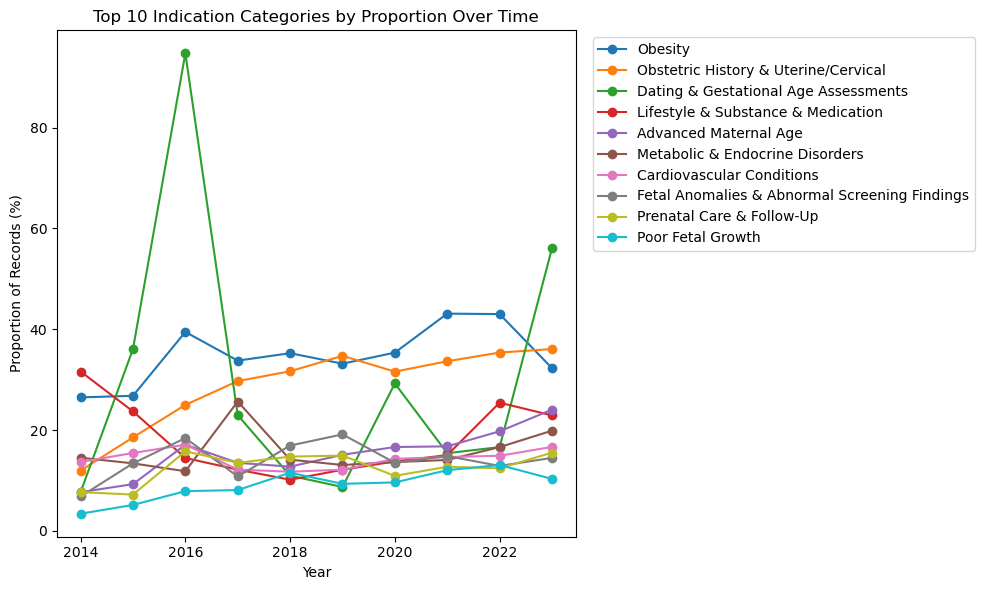

In [5]:
fractions = merged[dummy_cols].mean()
percentages = fractions.sort_values(ascending=False)
print("Indication prevalence (% of scans):\n", percentages)

# 1. Turn yearly counts into yearly proportions
merged["year"] = merged["date_time"].dt.year
yearly_prop = merged.groupby('year')[dummy_cols].mean() * 100

# 2) find the top 10 indicators by their overall proportion
overall_prop = merged[dummy_cols].mean() * 100
top10 = overall_prop.sort_values(ascending=False).head(10).index

# 3) subset your yearly_prop to just those top-10 columns
yearly_top10 = yearly_prop[top10]

# 4) plot
plt.figure(figsize=(10,6))
yearly_top10.plot(kind="line", marker="o", ax=plt.gca(), legend=False)
plt.title("Top 10 Indication Categories by Proportion Over Time")
plt.xlabel("Year")
plt.ylabel("Proportion of Records (%)")
plt.legend(yearly_top10.columns, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

Top indication categories (sorted):


,Count,Percent
Obesity,2289,37.77
Obstetric History & Uterine/Cervical,2026,33.43
Dating & Gestational Age Assessments,1502,24.79
Lifestyle & Substance & Medication,1143,18.86
Advanced Maternal Age,1092,18.02
Metabolic & Endocrine Disorders,955,15.76
Cardiovascular Conditions,880,14.52
Fetal Anomalies & Abnormal Screening Findings,880,14.52
Prenatal Care & Follow‑Up,798,13.17
Poor Fetal Growth,668,11.02


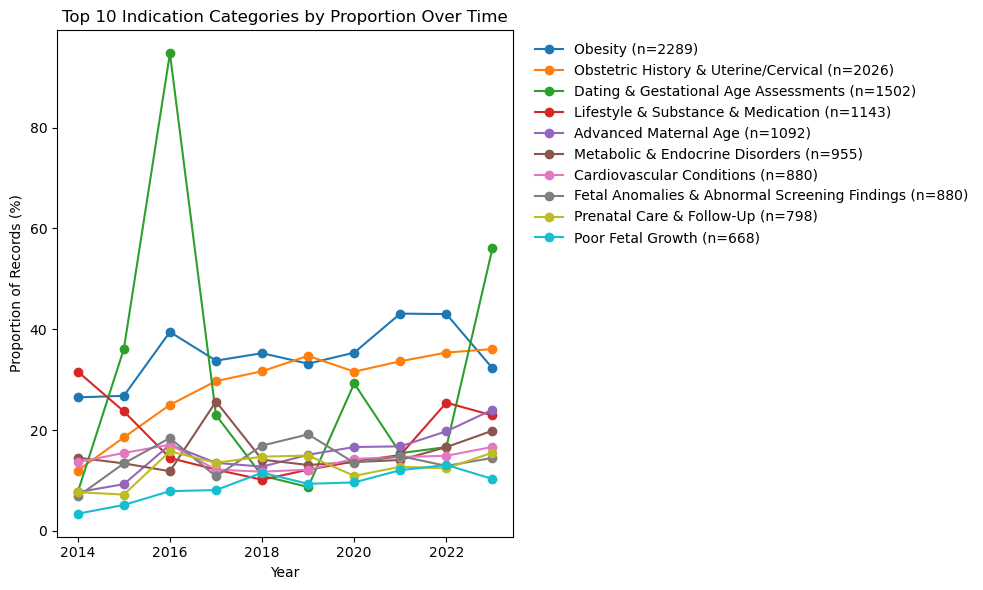

In [17]:
# -------------------------------------------------------
# Table
# -------------------------------------------------------
total_n         = len(merged)
counts          = merged[dummy_cols].sum()                      # raw N
percentages     = (counts / total_n * 100).round(2)             # %
summary_df      = (
    pd.DataFrame({'Count': counts, 'Percent': percentages})
      .sort_values('Percent', ascending=False)
)

display(summary_df)   # or summary_df.to_markdown() for plain text

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
merged['year']  = merged['date_time'].dt.year
yearly_prop     = merged.groupby('year')[dummy_cols].mean()*100


top10_names     = summary_df.head(10).index                   
yearly_top10    = yearly_prop[top10_names]


fig, ax = plt.subplots(figsize=(10, 6))

yearly_top10.plot(kind='line', marker='o', ax=ax, legend=False)

# Re-assign readable labels with N
for line, name in zip(ax.lines, top10_names):
    line.set_label(f"{name} (n={counts[name]})")

ax.set_title("Top 10 Indication Categories by Proportion Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of Records (%)")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()


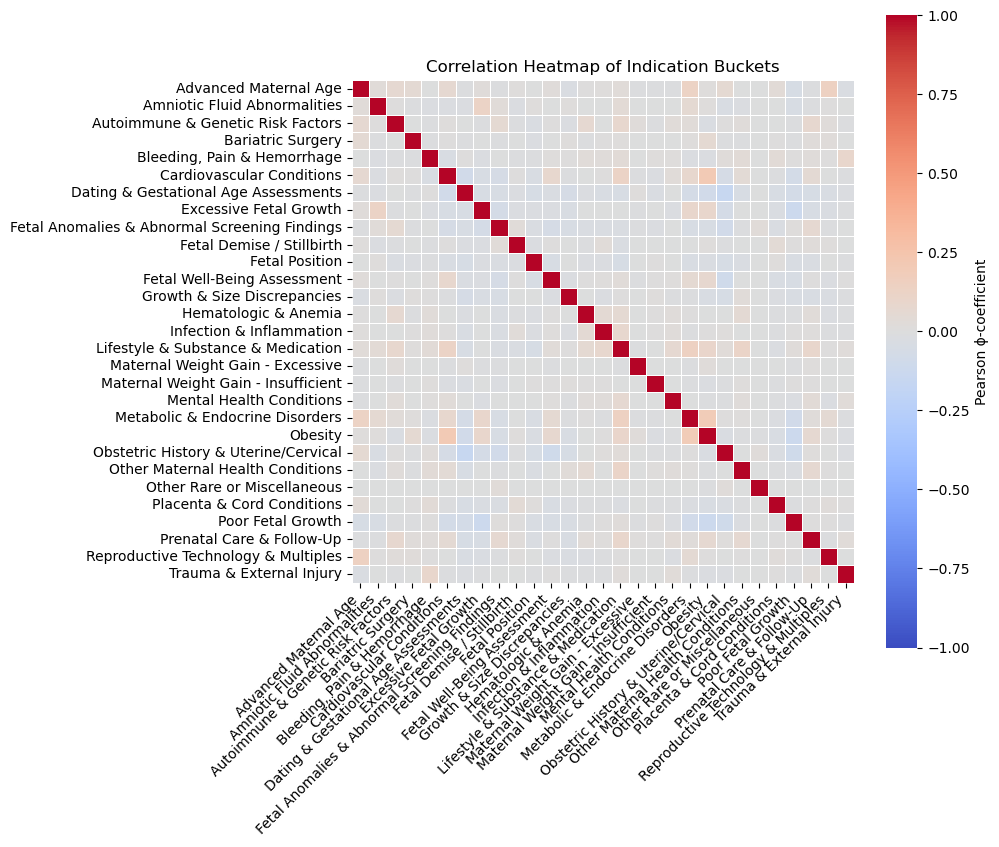

In [6]:
corr = merged[dummy_cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(
    corr,
    cmap="coolwarm",      # blue-to-red diverging palette
    vmin=-1, vmax=1,      # correlations range from -1 to +1
    center=0,             # put zero in the middle of the colorbar
    annot=False,          # omit numbers for clarity (or set True + fmt=".2f")
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink":.8, "label":"Pearson ϕ‑coefficient"}
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Correlation Heatmap of Indication Buckets")
plt.tight_layout()
plt.show()

In [10]:
dummies = merged[dummy_cols]
phi = dummies.corr()
# melt into long form
pairs = (
    phi
    .where(~np.eye(len(phi),dtype=bool))        # mask out the diagonal
    .stack()                                    # drop NaNs and turn into Series
    .reset_index()
    .rename(columns={'level_0':'ind1','level_1':'ind2',0:'phi'})
)

strong_pairs = pairs.sort_values('phi', ascending=False).head(20)
# 2) sort by descending φ to see the strongest co‑occurrences first
strong_pairs = strong_pairs.sort_values('phi', ascending=False).reset_index(drop=True)


strong_pairs_unique = strong_pairs[strong_pairs['ind1'] < strong_pairs['ind2']] \
                          .reset_index(drop=True)
strong_pairs_unique.head(10)


,ind1,ind2,phi
0,Cardiovascular Conditions,Obesity,0.205393
1,Metabolic & Endocrine Disorders,Obesity,0.188023
2,Advanced Maternal Age,Reproductive Technology & Multiples,0.141208
3,Lifestyle & Substance & Medication,Metabolic & Endocrine Disorders,0.141094
4,Advanced Maternal Age,Metabolic & Endocrine Disorders,0.128334
5,Amniotic Fluid Abnormalities,Excessive Fetal Growth,0.124147
6,Cardiovascular Conditions,Lifestyle & Substance & Medication,0.120948
7,Lifestyle & Substance & Medication,Other Maternal Health Conditions,0.110547
8,Lifestyle & Substance & Medication,Obesity,0.101155
9,Excessive Fetal Growth,Obesity,0.089445


## Statistical Analysis 

## Without Correction 

In [11]:
results = []
dummy_cols

for A, B in itertools.combinations(dummy_cols, 2):
    ct = pd.crosstab(merged[A], merged[B])
    chi2, p, _, exp = chi2_contingency(ct)
    if (exp < 5).any():
        # small counts → Fisher’s exact
        _, p = fisher_exact(ct)
        test = 'fisher'
    else:
        test = 'chi2'
    # only keep highly significant
    if p < 0.01:
        results.append({
            'A': A,
            'B': B,
            'test': test,
            'chi2': chi2,
            'p_value': p
        })

# 2. Create the DataFrame with named columns
summary = pd.DataFrame(results).sort_values('p_value')

# 1. Build the long table
long_table = summary[['A', 'B', 'p_value']]



display(long_table)

,A,B,p_value
28,Cardiovascular Conditions,Obesity,2.783306e-57
81,Metabolic & Endocrine Disorders,Obesity,2.788502e-48
41,Dating & Gestational Age Assessments,Obstetric History & Uterine/Cervical,5.700147e-33
76,Lifestyle & Substance & Medication,Metabolic & Endocrine Disorders,7.537062e-28
7,Advanced Maternal Age,Reproductive Technology & Multiples,8.339453e-28
...,...,...,...
37,Dating & Gestational Age Assessments,Infection & Inflammation,7.947885e-03
68,Growth & Size Discrepancies,Obesity,8.074168e-03
70,Growth & Size Discrepancies,Poor Fetal Growth,9.144481e-03
84,Obesity,Placenta & Cord Conditions,9.382927e-03


## Benjamini–Hochberg FDR correction

In [12]:
from statsmodels.stats.contingency_tables import Table2x2 
from IPython.display import display
results = []
dummy_cols

for A, B in itertools.combinations(dummy_cols, 2):
    # Build 2×2 table with rows = A (1,0), cols = B (1,0)
    ct = pd.crosstab(merged[A], merged[B]).reindex(index=[1,0], columns=[1,0], fill_value=0)
    arr = ct.values  # [[a, b],[c, d]]
    
    # Use Table2x2 for OR and CI
    tbl = Table2x2(arr)
    or_val = tbl.oddsratio
    ci_low, ci_upp = tbl.oddsratio_confint(alpha=0.05)  # 95% CI
    
    # Chi-square test
    chi2_stat, p_chi2, _, exp = chi2_contingency(arr)
    
    # Decide on test and p-value
    if (exp < 5).any():
        test_type = 'fisher'
        _, p_val = fisher_exact(arr)
        chi2_val = np.nan
    else:
        test_type = 'chi2'
        p_val = p_chi2
        chi2_val = chi2_stat
    
    results.append({
        'A': A,
        'B': B,
        'test': test_type,
        'chi2': chi2_val,
        'p_value': p_val,
        'odds_ratio': or_val,
        'ci_lower': ci_low,
        'ci_upper': ci_upp
    })

        
# 2. Build DataFrame of all tests
test_result = pd.DataFrame(results)

# 3. Run Benjamini–Hochberg at α = 0.01
reject, p_fdr, _, _ = multipletests(
    test_result['p_value'],
    alpha=0.01,
    method='fdr_bh'
)
test_result['p_fdr']      = p_fdr
test_result['reject_fdr'] = reject

# 4. Add a human-readable significance column
test_result['significance'] = np.where(
    test_result['reject_fdr'],
    'significant',
    'not significant'
)



# 5. (Optional) reorder/display
cols = ['A','B','test','chi2','p_value','p_fdr','significance','odds_ratio','ci_lower','ci_upper']
test_result = test_result[cols]


display(test_result)

# 6. Export
#test_result.to_excel("all_pairwise_tests_with_significance.xlsx", index=False)

,A,B,test,chi2,p_value,p_fdr,significance,odds_ratio,ci_lower,ci_upper
0,Advanced Maternal Age,Amniotic Fluid Abnormalities,chi2,3.710884,5.405875e-02,0.185968,not significant,1.262840,1.002932,1.590103
1,Advanced Maternal Age,Autoimmune & Genetic Risk Factors,chi2,26.587442,2.518757e-07,0.000003,significant,1.757339,1.418655,2.176878
2,Advanced Maternal Age,Bariatric Surgery,chi2,12.410911,4.268326e-04,0.002888,significant,3.728916,1.788402,7.774994
3,Advanced Maternal Age,"Bleeding, Pain & Hemorrhage",chi2,0.033398,8.549941e-01,1.000000,not significant,0.919468,0.543691,1.554967
4,Advanced Maternal Age,Cardiovascular Conditions,chi2,23.338662,1.358419e-06,0.000014,significant,1.527363,1.287165,1.812384
...,...,...,...,...,...,...,...,...,...,...
401,Poor Fetal Growth,Reproductive Technology & Multiples,chi2,0.000000,1.000000e+00,1.000000,not significant,1.007054,0.743928,1.363246
402,Poor Fetal Growth,Trauma & External Injury,fisher,NaN,7.627726e-01,1.000000,not significant,0.619774,0.146772,2.617113
403,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,chi2,0.759110,3.836072e-01,0.731195,not significant,0.868107,0.646850,1.165047
404,Prenatal Care & Follow‑Up,Trauma & External Injury,fisher,NaN,8.489961e-02,0.271411,not significant,2.208597,0.935848,5.212276


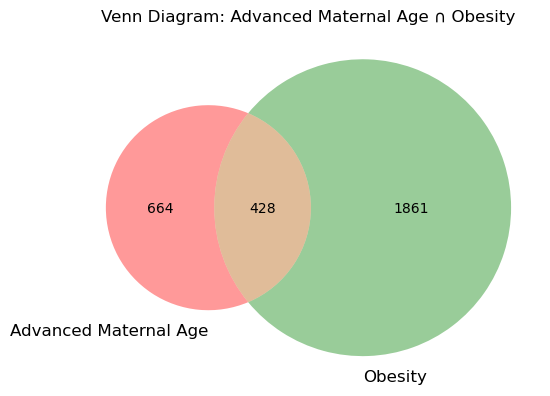

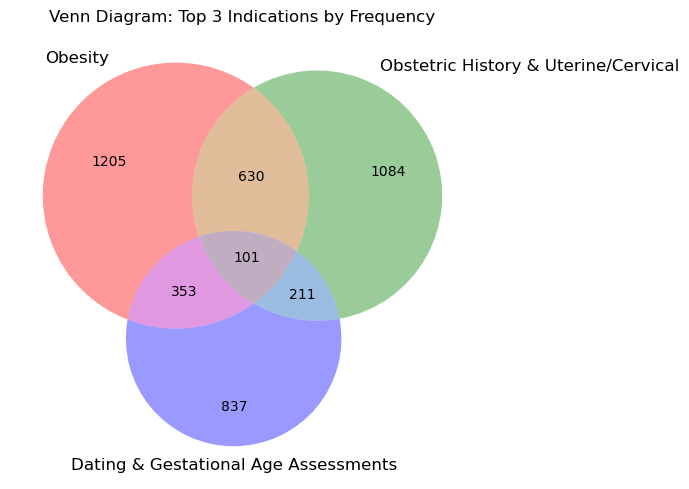

In [13]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# For Venn diagrams
from matplotlib_venn import venn2, venn3

# For network graph
import networkx as nx
from scipy.stats import chi2_contingency

# -------------------------------------------------------------------
# 1. Venn diagrams
# -------------------------------------------------------------------

# Example A: any TWO indications
A, B = 'Advanced Maternal Age', 'Obesity'
setA = set( merged.index[ merged[A] == 1 ] )
setB = set( merged.index[ merged[B] == 1 ] )

plt.figure(figsize=(6,6))
venn2([setA, setB], set_labels=(A, B))
plt.title(f"Venn Diagram: {A} ∩ {B}")
plt.show()

# Example B: top THREE most‐common indications
counts = merged[dummy_cols].sum().sort_values(ascending=False)
top3 = counts.head(3).index.tolist()           # e.g. ['Infection & Inflammation', 'Prenatal Care & Follow-Up', ...]
sets3 = [ set( merged.index[ merged[col]==1 ] ) for col in top3 ]

plt.figure(figsize=(6,6))
venn3(sets3, set_labels=top3)
plt.title("Venn Diagram: Top 3 Indications by Frequency")
plt.show()



In [14]:
unique_vals = merged['location'].dropna().unique()
print(unique_vals)

['Highland' 'Lattimore' 'Red Creek' '3-1406' 'Highland POB'
 'Highland Culver Road' 'Highland InPatient' '3-1420' 'Highland IP']


In [15]:
merged['location'].nunique()

9

## Table 1

In [20]:
merged.shape

(6060, 210)

In [25]:
moms = merged.drop_duplicates(subset="MRN")   # 1 row per mother
total_n = len(moms)                           # new N for Table 1 header

print(f"Unique mothers (N) = {total_n:,}")


Unique mothers (N) = 5,940


In [26]:
summary = (
    moms['sex_of_inf'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(2))
)

print(summary)

   Category     n    pct
0    1:Male  2993  50.39
1  2:Female  2947  49.61


In [27]:
summary = (
    moms['plurality'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(2))
)

print(summary)

   Category     n    pct
0  1:Single  5818  97.95
1    2:Twin   122   2.05


In [30]:
# --------------------------------------------------
# 2)  Define the grouped race categories
race_groups = {
    "American Indian or Alaska Native": ["mom_aina"],
    "Asian":  [
        "mom_si", "mom_chi", "mom_fil",
        "mom_jap", "mom_kor", "mom_vie", "mom_oas"
    ],
    "Black":  ["mom_bla"],
    "Pacific Islander/Native Hawaiian": [
        "mom_nha", "mom_gua", "mom_sam", "mom_opi"
    ],
    "Other":  ["mom_oth"],
    "White":  ["mom_whi"],
}

# --------------------------------------------------
# 3)  Calculate counts & percentages
rows = []
for category, cols in race_groups.items():
    # any() is TRUE if the mother is flagged “1:Yes” in ANY of the columns in that group
    mask = moms[cols].eq("1:Yes").any(axis=1)
    count = int(mask.sum())
    pct   = round(100 * count / total_n, 1)
    rows.append({"Race Category": category,
                 "Count (Percent)": f"{count:,} ({pct}%)"})

race_table = pd.DataFrame(rows)
print(race_table.to_string(index=False))

                   Race Category Count (Percent)
American Indian or Alaska Native       51 (0.9%)
                           Asian      295 (5.0%)
                           Black   1,443 (24.3%)
Pacific Islander/Native Hawaiian       10 (0.2%)
                           Other      276 (4.6%)
                           White   4,078 (68.7%)


In [32]:
summary = (
    moms['mhis_no'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

       Category     n   pct
0  Not Hispanic  5404  91.0
1      Hispanic   536   9.0


In [33]:
summary = (
    moms['mom_educ'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

                           Category     n   pct
0         3:High School Grad or GED  1279  21.5
1               6:Bachelor's degree  1248  21.0
2                 7:Master's degree   988  16.6
3  4:Some college credit, no degree   925  15.6
4                5:Associate degree   615  10.4
5      2:9th-12th grade, no diploma   417   7.0
6              8:Doctorate's degree   303   5.1
7                         9:Unknown    95   1.6
8               1:8th Grade or less    70   1.2


In [34]:
summary = (
    moms['mom_employ'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

  Category     n   pct
0    1:Yes  4069  68.5
1     0:No  1871  31.5


In [49]:
var = moms["mom_age"]                 # ← just change this
miss_n   = var.isna().sum()
miss_pct = miss_n / total_n * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         30.3 (5.45)
Median [Min, Max]: 31.0 [13.0, 52.0]
Missing (n, %):      0 (0.0%)


In [52]:
var = moms["tot_preg"]                 # ← just change this

miss_n   = var.isna().sum()
miss_pct = miss_n / total_n * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")


Mean (SD):         1.9 (2.06)
Median [Min, Max]: 1.0 [0.0, 22.0]
Missing (n, %):      21 (0.4%)


In [53]:
var = moms["live_livex"]                 # ← just change this

miss_n   = var.isna().sum()
miss_pct = miss_n / total_n * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         1.1 (1.33)
Median [Min, Max]: 1.0 [0.0, 18.0]
Missing (n, %):      22 (0.4%)


In [56]:

# --------------------------------------------------
# 1)  Boolean flags (new column name : original raw column)
risk_map = {
    "abruptio_placenta"    : "abrupt",
    "diabetes_gestational" : "diabetes_g",
    "diabetes_prepreg"     : "diabetes_m",
    "hypertension_prepreg" : "hyper_chro",
    "hypertension_preg"    : "hyper_preg",
    "eclampsia"            : "eclampsiax",
    "infertility_treat"    : "inferti",
    "infert_med_flag"      : "infert_med",
    "infert_art_flag"      : "infert_art",
    "other_chronic"        : "other_ill",
    "poor_outcome"         : "poor_preg",
    "prelab_referral"      : "prelab_ref",
    "preterm_prev"         : "pre_term_m",
    "previous_cs"          : "prev_cs",
    "unknown_risk"         : "unk_risk",
    "vaginal_bleeding"     : "vag_"
}

for new, raw in risk_map.items():
    moms[new] = moms[raw].astype(str).eq("1:Yes")

# --------------------------------------------------
# 2)  Pretty labels for the table
label_map = {
    "abruptio_placenta"    : "Abruptio Placenta",
    "diabetes_gestational" : "Diabetes, gestational",
    "diabetes_prepreg"     : "Diabetes, pre-pregnancy",
    "hypertension_prepreg" : "Hypertension, pre-pregnancy",
    "hypertension_preg"    : "Hypertension, pregnancy-related",
    "eclampsia"            : "Eclampsia",
    "infertility_treat"    : "Infertility Treatments",
    "infert_med_flag"      : "Infertility/Fertility Enhancing Drugs",
    "infert_art_flag"      : "Infertility/Assisted Reproductive Technology",
    "other_chronic"        : "Other Serious Chronic Diseases",
    "poor_outcome"         : "Poor pregnancy outcomes",
    "prelab_referral"      : "Pre-labor Referral for High Risk",
    "preterm_prev"         : "Pre-term infant, previous",
    "previous_cs"          : "Previous Cesarean Section",
    "unknown_risk"         : "Unknown",
    "vaginal_bleeding"     : "Vaginal bleeding"
}

# --------------------------------------------------
# 3)  Summarise (multiple responses allowed)
rows = []
for col in risk_map.keys():
    n   = int(moms[col].sum())
    pct = round(n / total_n * 100, 1)
    rows.append({
        "Pregnancy Risk Factor": label_map[col],
        "Count (Percent)"      : f"{n} ({pct}%)"
    })

risk_table = pd.DataFrame(rows).sort_values("Count (Percent)", ascending=False)
print(risk_table.to_string(index=False))


                       Pregnancy Risk Factor Count (Percent)
            Pre-labor Referral for High Risk     839 (14.1%)
                            Vaginal bleeding     793 (13.4%)
                           Abruptio Placenta       75 (1.3%)
                 Hypertension, pre-pregnancy     716 (12.1%)
                       Diabetes, gestational     609 (10.3%)
              Other Serious Chronic Diseases      501 (8.4%)
                                     Unknown       48 (0.8%)
                   Pre-term infant, previous      374 (6.3%)
                      Infertility Treatments      348 (5.9%)
                     Poor pregnancy outcomes      320 (5.4%)
Infertility/Assisted Reproductive Technology      209 (3.5%)
       Infertility/Fertility Enhancing Drugs      200 (3.4%)
                     Diabetes, pre-pregnancy      192 (3.2%)
             Hypertension, pregnancy-related    1122 (18.9%)
                   Previous Cesarean Section    1012 (17.0%)
                        

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_57631/2826811839.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moms[new] = moms[raw].astype(str).eq("1:Yes")
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_57631/2826811839.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moms[new] = moms[raw].astype(str).eq("1:Yes")
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_57631/2826811839.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [54]:
summary = (
    moms['none_congm'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

                           Category     n   pct
0  1:No Congenitial anomaly present  5744  96.7
1     0:Congenitial anomaly present   196   3.3
